In [160]:
from collections import Counter

from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from tqdm.auto import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

In [131]:
nlp = spacy.load("en_core_web_sm")
tqdm.pandas()

In [132]:
def pronoun_analysis(df: pd.DataFrame):
    """
    Determines the person used in the text from pronoun analysis. Populates new column
    in the dataframe with 1 (first-person), 2 (third-person) or 0 (mixed/undefined)

    Args:
        df (pd.DataFrame): analysis dataframe
    """

    # Determine person from pronoun analysis
    def determine_pronoun(text: str):
        if not isinstance(text, str) or len(text.strip()) == 0:
            return 0
        
        doc = nlp(text)
        pronoun_counts = Counter()

        # Pronoun sets
        first_person = {"i", "me", "my", "mine", "we", "us", "our", "ours"}
        third_person = {"he", "him", "his", "she", "her", "they", "them", "their", "theirs", "it", "its"}
        person_threshold_ratio = 1

        # Count different first and third person pronouns
        for token in doc:
            if token.pos_ == "PRON":
                pronoun = token.text.lower()
                if pronoun in first_person:
                    pronoun_counts["first"] += 1
                elif pronoun in third_person:
                    pronoun_counts["third"] += 1

        if pronoun_counts["first"] > pronoun_counts["third"] * person_threshold_ratio:
            return 1
        elif pronoun_counts["third"] > pronoun_counts["first"] * person_threshold_ratio:
            return 2
        else:
            return 0
        
    df["person"] = df["content"].progress_apply(determine_pronoun)

In [ ]:
def plot_proportion_person(df: pd.DataFrame, out_filename: str, subreddit: str):
    """Plot proportion of first/third person accounts in positive and negative sentiment posts"""
    
    local_df = df[["person", "sentiment"]]
    local_df = df[df["person"] != 0]  # Remove undefined person rows
    positive_first = local_df[(local_df["sentiment"] == "Positive") & (local_df["person"] == 1)]
    negative_first = local_df[(local_df["sentiment"] == "Negative") & (local_df["person"] == 1)]
    all_positive = local_df[local_df["sentiment"] == "Positive"]
    all_negative = local_df[local_df["sentiment"] == "Negative"]

    prop_df = pd.DataFrame({
        "Sentiment": ["Positive", "Negative"],
        "Proportion": [len(positive_first) / len(all_positive), len(negative_first) / len(all_negative)],
        "Total": [len(all_positive), len(all_negative)]
    })
    prop_df["first_person"] = prop_df["Proportion"] * prop_df["Total"]

    ax = sns.barplot(prop_df, x="Sentiment", y="Total", color="lightblue")
    sns.barplot(prop_df, x="Sentiment", y="first_person", color="blue", ax=ax)
    ax.set_ylabel("First Person Accounts/Total Accounts")
    
    plt.savefig(f"../../plots/{subreddit}/{out_filename}.png")

In [149]:
subreddit = "loseit"
filename = "loseit_topall_searchOzempic"
df = pd.read_parquet("../../data/reddit/nlp_analysis/loseit_topall_searchOzempic.parquet")

In [158]:
min_score = df["mh_score"].min()
max_score = df["mh_score"].max()

# Avoid division by zero if all values are the same
if max_score > min_score:
    df["mh_score_norm"] = (df["mh_score"] - min_score) / (max_score - min_score)
else:
    df["mh_score_norm"] = 0.0  # or any constant, since all values are equal


count = 0

for index, row in df.iterrows():
    if count == 5:
        break
    if row["mh_score_norm"] > 0.9:
        print(row["content"])
        count += 1


I'm not on any meds, but I went through a long journey of healing from binge-eating, and my experience feels really similar, as in, I suddenly discovered that I can feel SATIETY before I'm finished eating. Many things are genuinely too much. I used to get a big tasty at McDonald's for as long as I can remember, and now suddenly I have to only eat half, because otherwise I feel stuffed, and it's unpleasant. Restaurant portions are too big for me very often. I feel like with this new state of things losing weight and keeping it off is just ridiculously easy (kinda). I'm no longer suprised that some people just never have issues with weight if that's how they've been living and feeling their whole lives! Of course I'll skip dinner if I had a big lunch! Eating when I'm not hungry sucks!!! Amazing.
Are you in therapy? It might help with a big life change like this. Congratulations on -150 lost!
Wow, this is so encouraging to me that people/partners like this actually exist. My ex made fun o

In [154]:
len(df[df["person"] == 2])

1413

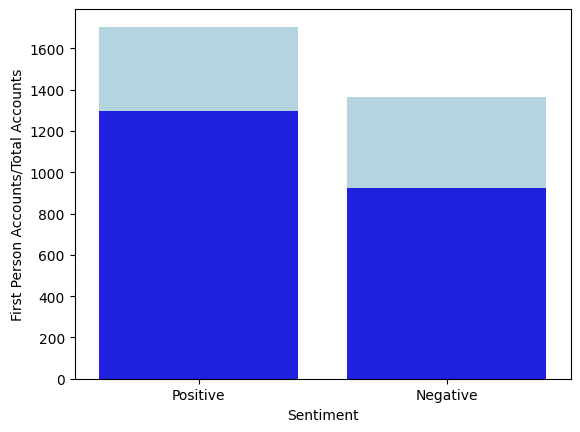

In [151]:
plot_proportion_person(df, filename, subreddit)

In [136]:
pronoun_analysis(df)

  0%|          | 0/6806 [00:00<?, ?it/s]

In [137]:
len(df[df["person"] == 2])

1611

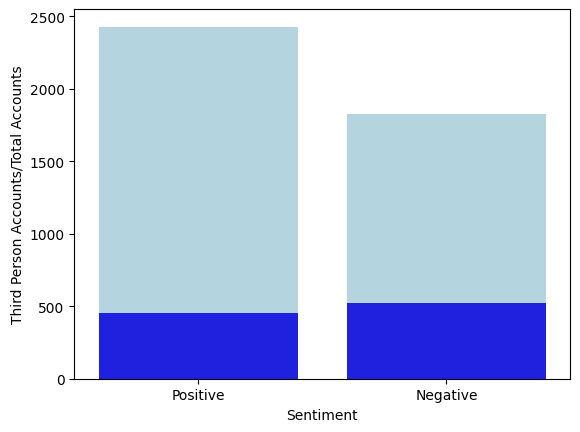

In [138]:
plot_proportion_person(df, filename, subreddit)

In [ ]:
df["is_negative"] = (df["sentiment"] == "Negative").astype(int)
df["is_thirdperson"] = (df["person"] == 2).astype(int)

corr, p_value = pearsonr(df["is_negative"], df["is_thirdperson"])

print(f"Correlation: {corr:.3f}")
print(f"P-Value: {p_value:.3e}")

Correlation: 0.052
P-Value: 1.615e-05
